# Navigation

---
## Start the Environment

Necessary packages have to be imported first. 

Before proceeding, please make sure that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and that the Banana Environment utilized by DQN-Agent is placed properly in your project folder. In case of doubts, refer to [README](https://github.com/rrstal/drlnd-dqn-agent-navigation/blob/master/README.md).

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from collections import deque

from unityagents import UnityEnvironment
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from models import QNetwork
from agents import DQNAgent

In [3]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Example of an agent taking random actions in the environment.

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


In [7]:
def dqn(agent, solved_thresh, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(int(action))[brain_name]   # perform the action
            next_state = env_info.vector_observations[0]   # get next state
            reward = env_info.rewards[0]                   # get reward
            done = env_info.local_done[0]                  # check done  
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.3f}'.format(i_episode, np.mean(scores_window), eps))
        if np.mean(scores_window)>=solved_thresh:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return agent, scores

In [8]:
%%time
agent = DQNAgent(state_size, action_size, seed=0, name="dqn")
agent, scores = dqn(agent, solved_thresh=13)

Episode 50	Average Score: 0.18	Epsilon: 0.778
Episode 100	Average Score: 0.72	Epsilon: 0.606
Episode 150	Average Score: 2.09	Epsilon: 0.471
Episode 200	Average Score: 4.15	Epsilon: 0.367
Episode 250	Average Score: 5.98	Epsilon: 0.286
Episode 300	Average Score: 6.73	Epsilon: 0.222
Episode 350	Average Score: 7.73	Epsilon: 0.173
Episode 400	Average Score: 8.69	Epsilon: 0.135
Episode 450	Average Score: 10.18	Epsilon: 0.105
Episode 500	Average Score: 12.05	Epsilon: 0.082
Episode 520	Average Score: 13.02
Environment solved in 470 episodes!	Average Score: 13.02
CPU times: user 3min 17s, sys: 22.8 s, total: 3min 39s
Wall time: 6min 17s


Plot the scores throghout the training

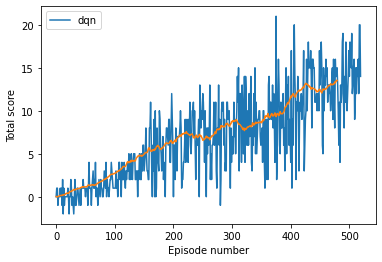

In [23]:
# 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='dqn')
plt.plot(np.arange(len(scores)), pd.DataFrame(scores).rolling(40).mean().shift(-40))
plt.legend()
plt.ylabel('Total score')
plt.xlabel('Episode number')
plt.show()

Smooth the scores via running average with defined window size

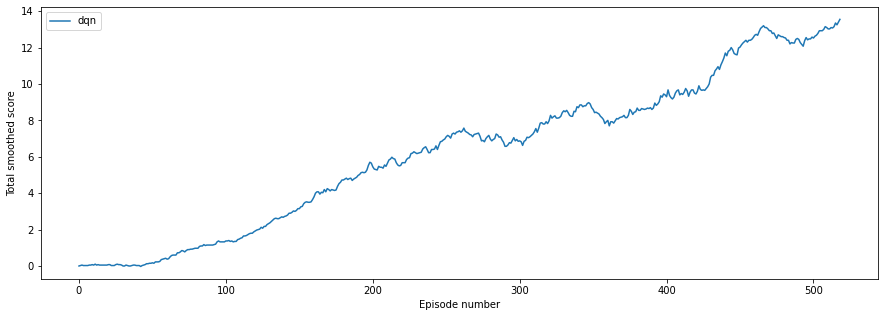

In [25]:
window = 40
filter = np.ones(window)/window
plt.figure(figsize=(15,5))
plt.plot(np.convolve(scores, filter)[:-window], label='dqn')
plt.legend()
plt.ylabel('Total smoothed score')
plt.xlabel('Episode number')
plt.show()

In [ ]:
env.close()
